In this notebook we will be exploring the King County, USA Housing data set and seeing how well we can get a simple multiple linear regression model to predict the housing prices.  To tackle this problem we will be using the tensorflow, pandas, and numpy libraries.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

Next we set our seeds and read in the data.

In [2]:
np.random.seed(7)
tf.set_random_seed(7)
init_data = pd.read_csv("../input/kc_house_data.csv")
print("Col: {0}".format(list(init_data)))

Col: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


Lets look at the data info to see what data types each of these columns are and see if there is any data missing.

In [3]:
print(init_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB
None


We can see that all of the data types are numeric except for "date". We can also tell that each column has 21613 rows and none of the columns have missing data. So now we need to get rid of "id", because this is useless, and "date", because we just want to deal with numeric values.

In [4]:
init_data = init_data.drop("id", axis=1)
init_data = init_data.drop("date", axis=1)

Now lets take a look at the how the rest of the data correlates with the "price" column.

In [5]:
matrix_corr = init_data.corr()
print(matrix_corr["price"].sort_values(ascending=False))

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
zipcode         -0.053203
Name: price, dtype: float64


As we can see we have quite a few strong correlated features, with "zipcode" being the only negative correlating feature. We might want to experiment with seeing which features are the best to remove but for right now we will just remove "zipcode" and test the rest of the features.

In [6]:
init_data = init_data.drop("zipcode", axis=1)

Lets graphically compare "price" to the top four correlated features to see if we can spot any trends or anomalies with the data.

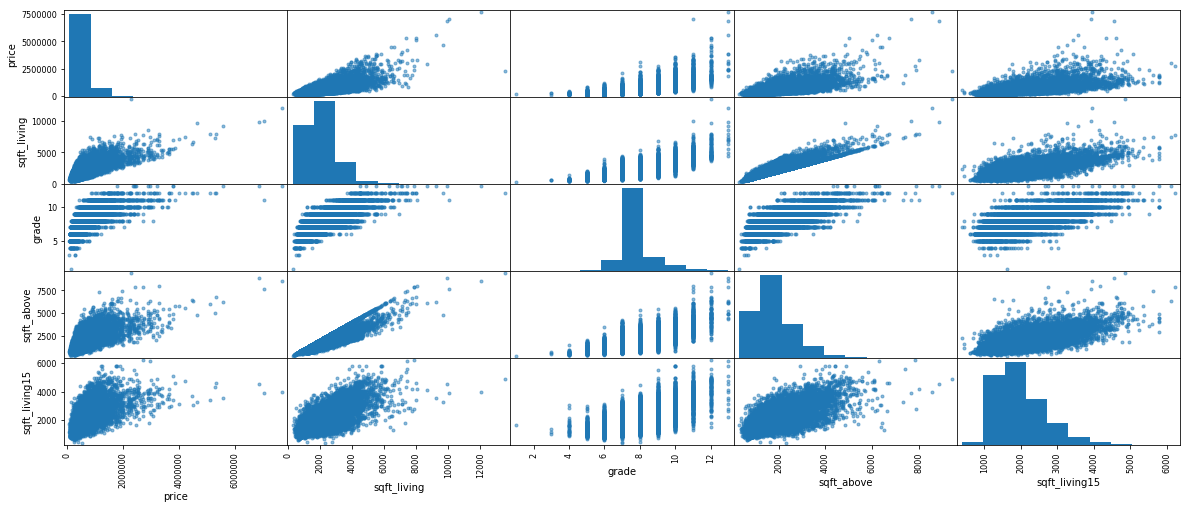

In [7]:
from pandas.tools.plotting import scatter_matrix
%matplotlib inline
## attributes to look at
attr = ["price", "sqft_living", "grade", "sqft_above", "sqft_living15"]
scatter_matrix(init_data[attr], figsize=(20,8) );

As we can see, it seems there are some possible outliers to worry about. So what we will do is standardize the data when we create our model so that we won't have to worry about this possible problem as much.

Now lets define a split function to permutate our data and split it into a training and test set that we can work with. We will have 80% as training data and 20% as test data.

In [8]:
def split_data(data, ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_data(init_data, 0.2)

We need to grab the mean and standard deviation of the training set to standardize our input data for the model later.

In [9]:
mean_offset = train_set.mean()
stddev_offset = train_set.std()
mean_xOffset = (mean_offset.drop("price")).values
stddev_xOffset = (stddev_offset.drop("price")).values
mean_yOffset = np.array([mean_offset["price"].copy()])
stddev_yOffset = np.array([stddev_offset["price"].copy()])

mean_xOffset = mean_xOffset.reshape(1, mean_xOffset.shape[0])
stddev_xOffset = stddev_xOffset.reshape(1, stddev_xOffset.shape[0])
mean_yOffset = mean_yOffset.reshape(1, mean_yOffset.shape[0])
stddev_yOffset = stddev_yOffset.reshape(1, stddev_yOffset.shape[0])

We need to split our training set into the data and its labels for our model. 

In [10]:
data = (train_set.drop("price", axis=1)).values
data_labels = (train_set["price"].copy()).values
data_labels = data_labels.reshape([len(data_labels),1]) # forcing a [None, 1] shape

Next lets pull out some info we need to help set up our model, like the number of features we are using and the number of samples that we have.

In [11]:
num_features = data.shape[1]
n_samples = data.shape[0]

Now its time to implement our model. We will define our inputs along with the weights and biases.

In [12]:
X_init = tf.placeholder(tf.float32, [None, num_features])
Y_init = tf.placeholder(tf.float32, [None, 1])
W = tf.Variable(tf.random_normal([num_features,1]))
b = tf.Variable(tf.random_normal([1]))

Next what we are going to do is standardize our input data so that any possible outliers in the data won't be as big of a problem. Plus this makes the size of the values smaller and easier to work with.

In [13]:
##  Grab the mean and stddev values we took from the training set earlier
x_mean = tf.constant(mean_xOffset, dtype=tf.float32)
y_mean = tf.constant(mean_yOffset, dtype=tf.float32)

x_stddev = tf.constant(stddev_xOffset, dtype=tf.float32)
y_stddev = tf.constant(stddev_yOffset, dtype=tf.float32)

## Making the input have a mean of 0 and a stddev of 1
X = tf.div(tf.subtract(X_init, x_mean), x_stddev)
Y = tf.div(tf.subtract(Y_init, y_mean), y_stddev)

With all of that taken care of we can define the prediction function.

In [14]:
pred = tf.add(tf.matmul(X,W), b)

To calculate the loss we are going the use the Mean Squared Error(MSE) function.

In [15]:
pow_val = tf.pow(tf.subtract(pred, Y),2)
cost = tf.reduce_mean(pow_val)

Normally we would use the gradient descent optimizer to minimize our cost function but the Adam optimizer shows better results. We will also set its learning rate to 0.1, which is kind of high but in this case it converges decently in a short amount of epochs.

In [16]:
optimizer = tf.train.AdamOptimizer(1e-1).minimize(cost)

Now lets initalize our variables and start our tensorflow session.

In [17]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

We are going to define our for loop to iterate through 1000 epochs. We will also store our cost results to graph.

In [18]:
cost_values = []
num_epochs = 1000
for epoch in range(num_epochs): 
    _, c = sess.run([optimizer, cost], feed_dict={X_init:data, Y_init:data_labels})
    cost_values.append(c)

Just to see how our model looks lets print out the final cost, weights, and bias.

In [19]:
training = sess.run(cost, feed_dict={X_init:data, Y_init:data_labels})
print("Final cost: {0} final weights: {1} final biases: {2}".format(training, sess.run(W), sess.run(b)) )

Final cost: 0.3008064031600952 final weights: [[-0.08289298]
 [ 0.08201667]
 [-0.1147991 ]
 [ 0.00873815]
 [ 0.01180041]
 [ 0.14265192]
 [ 0.10099796]
 [ 0.05620537]
 [ 0.30636245]
 [ 0.50391531]
 [ 0.23961949]
 [-0.19724593]
 [ 0.02820019]
 [ 0.21111344]
 [-0.04459605]
 [ 0.05780244]
 [-0.02599087]] final biases: [ -1.62391223e-06]


Lets also look at our cost function values.

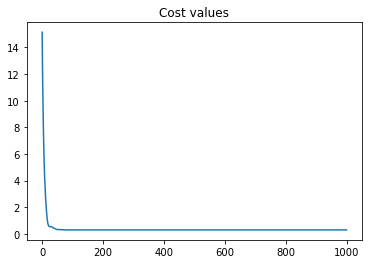

In [20]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.title("Cost values")
plt.plot(cost_values);

To see how well we did, we need to compute the R^2 to see how well our model explains the data, the Root Mean Squared Error(RMSE) to tell us standard deviation of our predicted values vs. the actual values, and the Adjusted R^2 function to make sure the regular R^2 function is not being influenced by the high number of features we have in our model.

In [21]:
## Defining R^2
ss_e = tf.reduce_sum(tf.pow(tf.subtract(Y, pred), 2))
ss_t = tf.reduce_sum(tf.pow(tf.subtract(Y, 0), 2))
r2 = tf.subtract(1.0, tf.div(ss_e, ss_t))

## Defining Adjusted R^2
adjusted_r2 = tf.subtract(1.0, tf.div(tf.div(ss_e, (n_samples - 1.0)), tf.div(ss_t, (n_samples - num_features - 1)) ) )

Now we grab all of the predictions and all of the standardized Y values. Then we compute the R^2, Adjusted R^2, and RMSE on our data.

In [22]:
pred_data = sess.run(pred, feed_dict={X_init:data, Y_init:data_labels})
std_y_data = sess.run(Y, feed_dict={Y_init:data_labels})
## computing rmse
rmse = np.sqrt(np.mean(np.power(np.subtract(pred_data, std_y_data), 2)))
print("rmse of pred_data and std_y_data is: {0}".format(rmse))
print("R^2 value: {0}".format(sess.run(r2,feed_dict={X_init:data, Y_init:data_labels})) )
print("Adjusted R^2 value: {0}".format(sess.run(adjusted_r2, feed_dict={X_init:data, Y_init:data_labels})))

rmse of pred_data and std_y_data is: 0.5484583973884583
R^2 value: 0.6991763114929199
Adjusted R^2 value: 0.6994720697402954


As we can see we have a RMSE of ~0.55, $R^2$ of ~0.70, and Adjusted $R^2$ of ~0.70 with our simple multiple linear regression model. 

Now lets see how well our model can predict our test data by comparing RMSE values.

In [23]:
rmse_train = np.sqrt(np.mean(np.power(np.subtract(pred_data, std_y_data), 2)))
print("RMSE for Training data is: {0}".format(rmse_train))

## run test set through model
test_data = (test_set.drop("price", axis=1)).values
test_data_labels = (test_set["price"].copy()).values
test_data_labels = test_data_labels.reshape([len(test_data_labels), 1])
test_pred = sess.run(pred, feed_dict={X_init:test_data, Y_init:test_data_labels})
test_data_labels = sess.run(Y, feed_dict={Y_init:test_data_labels})
rmse_test = np.sqrt(np.mean(np.power(np.subtract(test_pred, test_data_labels), 2)))
print("RMSE for Test data is: {0}".format(rmse_test))
print("RMSE difference: {0}".format(rmse_test - rmse_train))
sess.close()

RMSE for Training data is: 0.5484583973884583
RMSE for Test data is: 0.5595935583114624
RMSE difference: 0.01113516092300415


It seems that our model has a similar outcome for our test data as our training data with only a difference of ~0.01 with the RMSE values. So for a simple model this seems to be a good start.